# 1. Introuction

This notebook outlines the creation, compilation, and training of a ResNeXt101-32X8D CNN network to classify 101 types of food.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer, sec_to_min_sec
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Mon Jan 20 12:44:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   42C    P2             27W /  200W |    1506MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

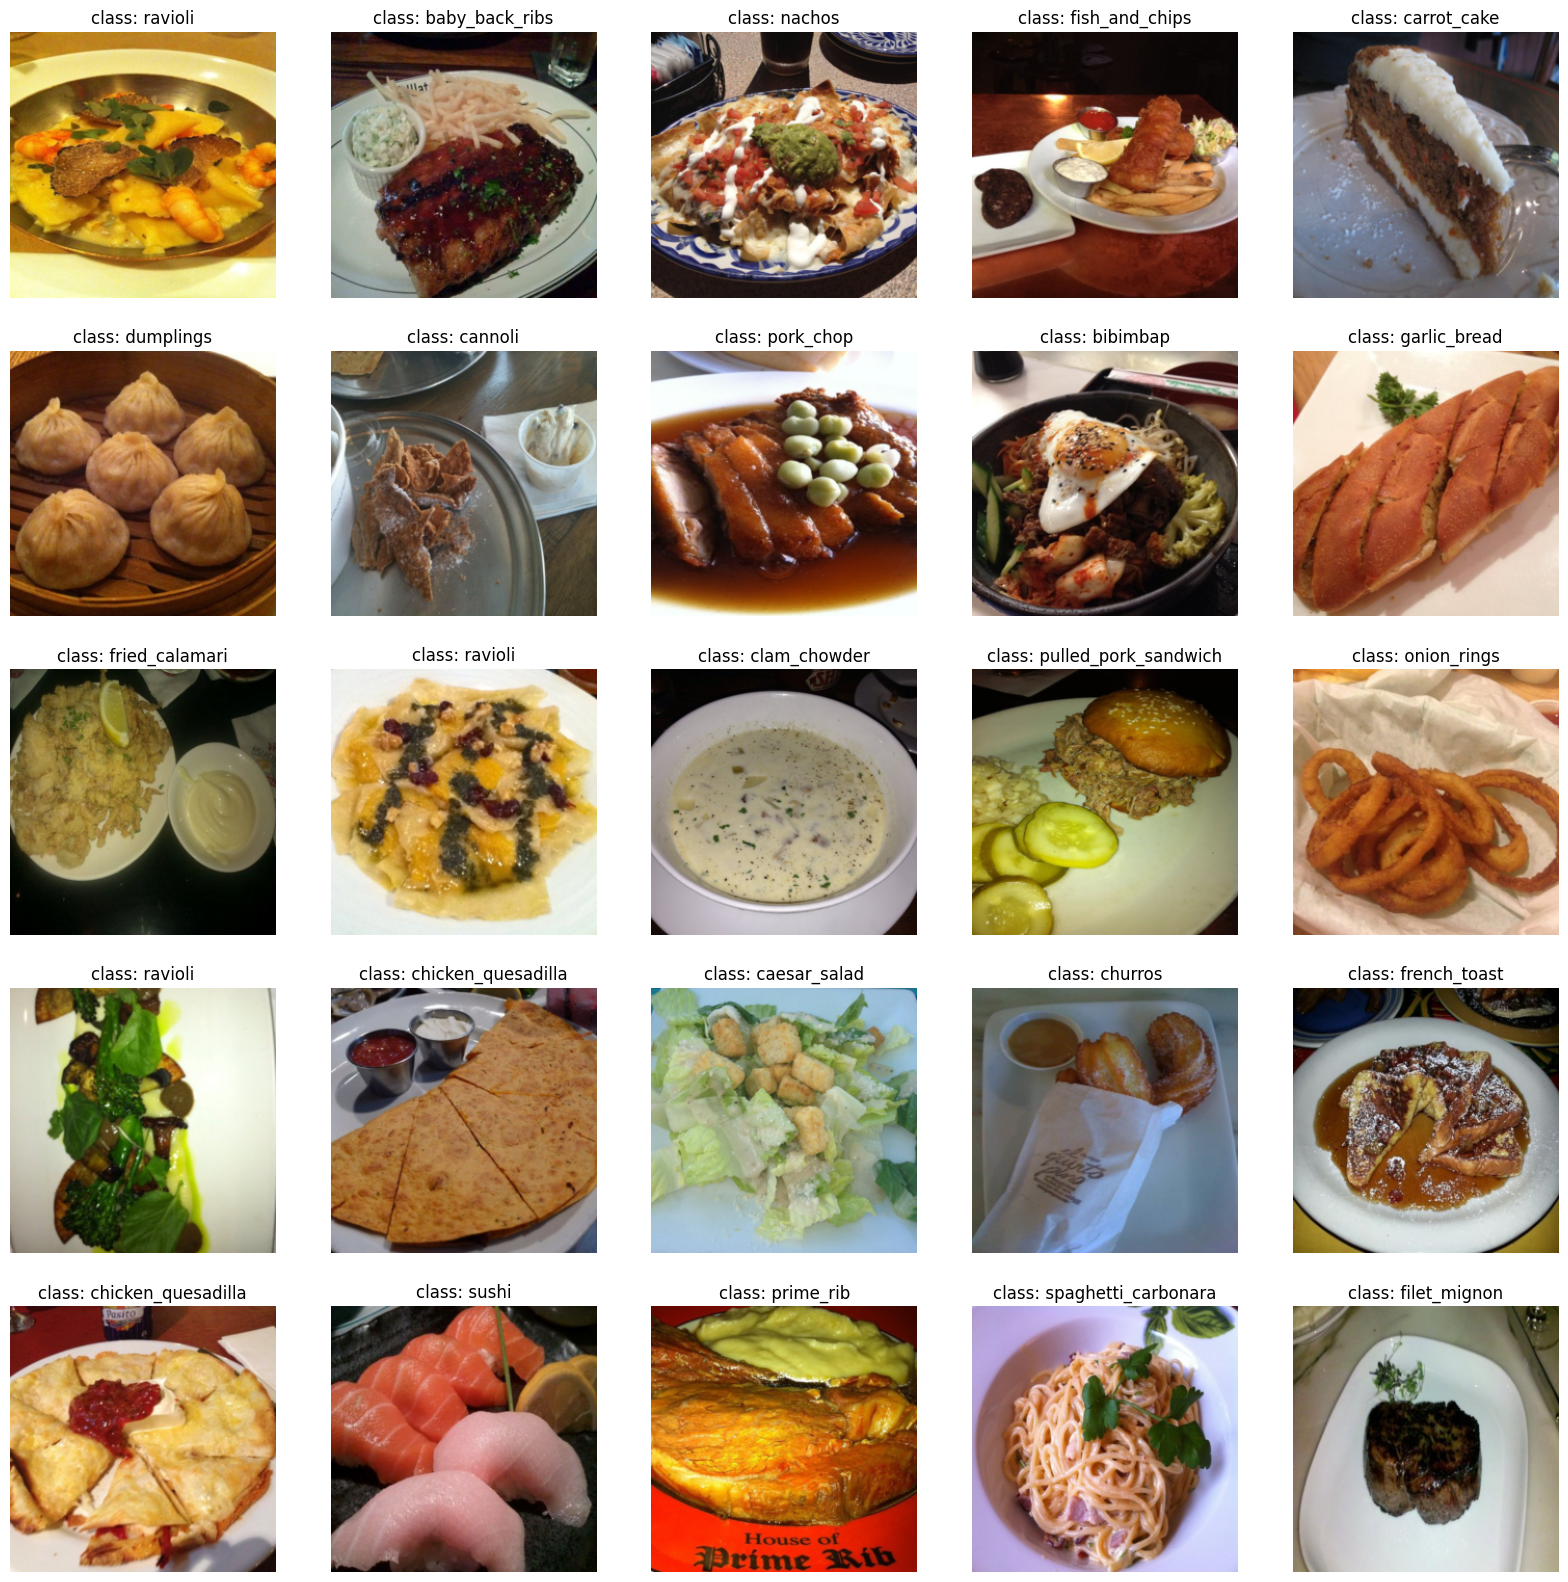

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's Swin Small Transformer

In [4]:
# Create transforms
IMG_SIZE_1 = 232
IMG_SIZE_2 = 224
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model = torchvision.models.resnext101_32x8d(
    weights=torchvision.models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2,
    )

model.fc = torch.nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

# Compile model
model = torch.compile(model, backend="aot_eager")

# Print summary
summary(model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0120 12:44:50.676000 28352 site-packages\torch\_dynamo\convert_frame.py:844] [11/8] torch._dynamo hit config.cache_size_limit (8)
W0120 12:44:50.676000 28352 site-packages\torch\_dynamo\convert_frame.py:844] [11/8]    function: 'torch_dynamo_resume_in_forward_at_147' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torchvision\models\resnet.py:147)
W0120 12:44:50.676000 28352 site-packages\torch\_dyna

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)             [32, 3, 224, 224]    [32, 101]            --                   True
├─ResNet (_orig_mod)                          [32, 3, 224, 224]    [32, 101]            --                   True
│    └─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]   

Epoch: 20 | train_loss: 0.8253 | train_acc: 0.9890 | fpr_at_recall: 0.0000 | train_time: 8m50s | test_loss: 1.1229 | test_acc: 0.8999 | fpr_at_recall: 0.0057 | test_time: 1m40s | lr: 0.0000016094


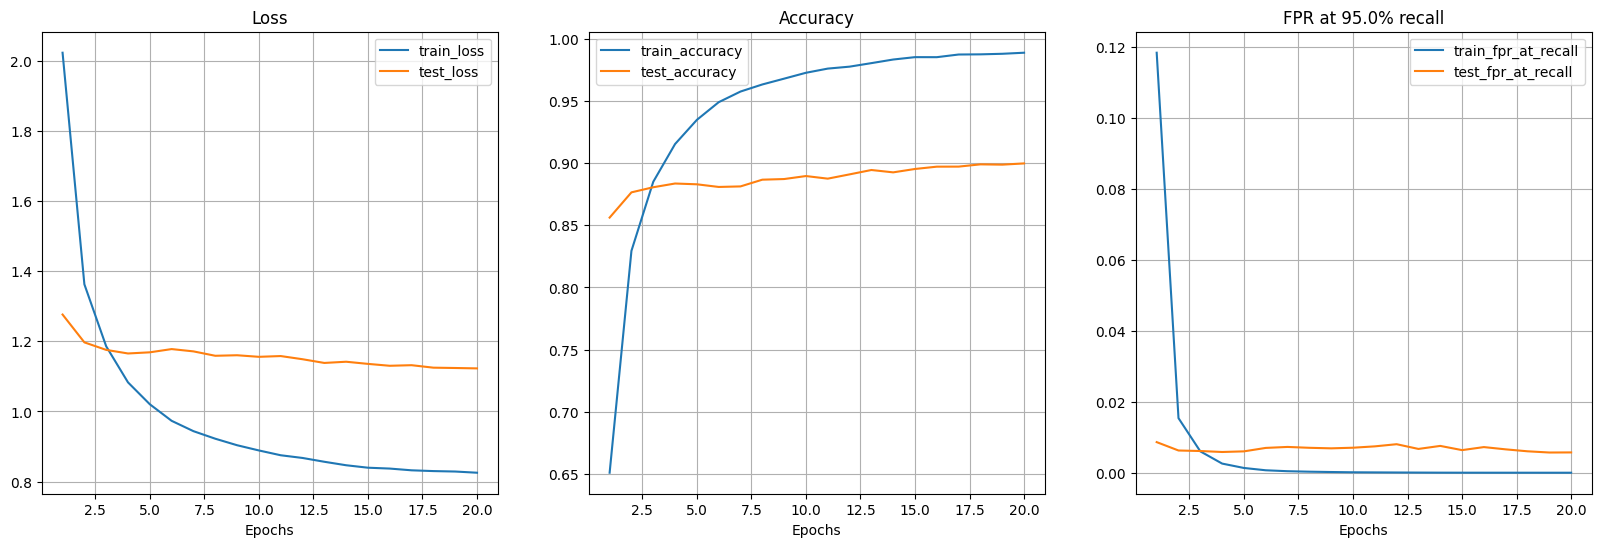

[INFO] Saving model to: ..\models\resnext_101_2025-01-19_loss.pth
[INFO] Saving model to: ..\models\resnext_101_2025-01-19_acc.pth
[INFO] Saving model to: ..\models\resnext_101_2025-01-19.pth


In [5]:
# Train the model
model_type="resnext_101_2025-01-19"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )

In [6]:
results

,epoch,train_loss,train_acc,train_fpr_at_recall,train_time [s],test_loss,test_acc,test_fpr_at_recall,test_time [s],lr
0,1,2.023321,0.650791,0.118264,560.374000,1.276479,0.856250,0.008630,110.596254,0.000100
1,2,1.362732,0.829462,0.015378,532.068788,1.197097,0.876582,0.006271,102.548339,0.000099
2,3,1.185843,0.885082,0.006031,532.265064,1.175633,0.880696,0.006125,100.274679,0.000098
3,4,1.082953,0.915492,0.002587,521.869813,1.165417,0.883703,0.005851,97.564440,0.000095
4,5,1.020524,0.934966,0.001352,521.091867,1.168710,0.883070,0.006027,98.523266,0.000091
5,6,0.973292,0.949192,0.000701,522.537979,1.177948,0.880934,0.006998,98.831428,0.000086
6,7,0.943803,0.957770,0.000440,522.879540,1.171385,0.881369,0.007274,98.416499,0.000080
7,8,0.922276,0.963467,0.000304,522.015102,1.158848,0.886788,0.007030,98.432669,0.000073
8,9,0.903691,0.968152,0.000212,522.692277,1.160354,0.887302,0.006878,98.253649,0.000066
9,10,0.888792,0.972881,0.000135,523.308083,1.155875,0.889715,0.007054,98.136431,0.000058


In [7]:
results = pd.read_csv(os.path.join(MODEL_DIR, "convb_101_2025-01-19.csv"))
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 8m38s
